In [1]:
import random
import torch

words = open('names.txt', 'r').read().splitlines()
words = sorted(list(set(words))) # set cause uncontrollable randomness， sorted for reproducibility
random.seed(42)
random.shuffle(words)
len(words)

chs = list(set(''.join(words + ['.'])))
chs = sorted(chs, reverse=False)
stoi = {ch: i for i, ch in enumerate(chs)}
itos = {i: ch for i, ch in enumerate(chs)}

# predict next token use previous 3 tokens
X, Y = [], []

for w in words:
    context = '...'
    for ch in w + '.':
        x = [stoi[c] for c in context]
        y = stoi[ch]
        X.append(x)
        Y.append(y)
        context = context[1:] + ch

X = torch.tensor(X)
Y = torch.tensor(Y)
n1, n2  = int(0.8 * len(X)), int(0.9 * len(X))

X_train, X_val, X_test = X.tensor_split([n1, n2])
Y_train, Y_val, Y_test = Y.tensor_split([n1, n2])

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape


(torch.Size([169062, 3]),
 torch.Size([21133, 3]),
 torch.Size([21133, 3]),
 torch.Size([169062]),
 torch.Size([21133]),
 torch.Size([21133]))

dataset should be split into 3 sets: train, val, test
- train: for track optimization process
- val: for hyperparameter tuning
- test: for testing, only used it very rarely to avoid overfitting


# search for initial lr

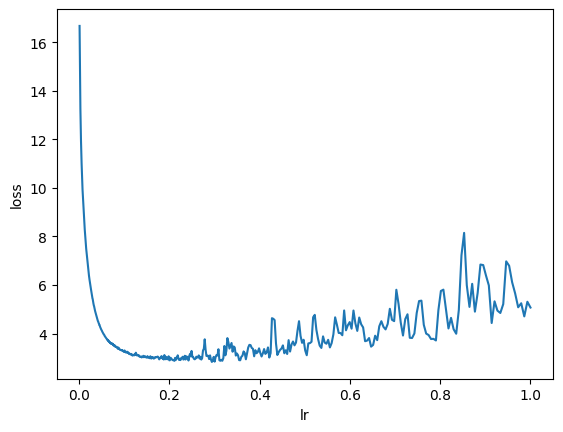

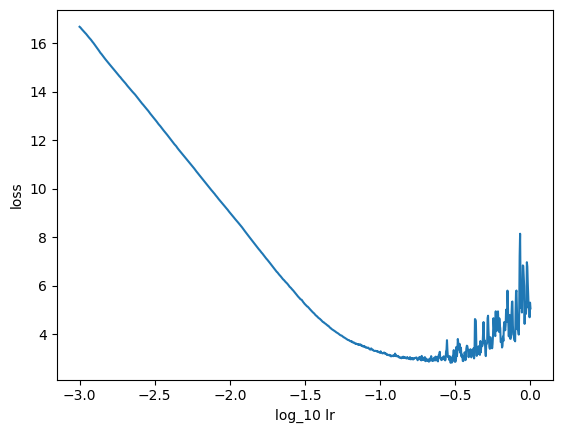

In [98]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(42)
C = torch.randn(27, 2)
w1 = torch.randn(6, 100)
b1 = torch.randn(100)
w2 = torch.randn(100, 27)
b2 = torch.randn(27)
params = [C, w1, b1, w2, b2]
for p in params:
    p.requires_grad = True

bs = 64
n_steps = 1000

lre = torch.linspace(-3, 0, n_steps)
lri = 10 ** lre
lossi = []


indices = torch.randperm(X_train.shape[0])
X_train, Y_train = X_train[indices], Y_train[indices]
for s in range(n_steps):
    x = X_train[s * bs:(s + 1) * bs]
    y = Y_train[s * bs:(s + 1) * bs]
    emb = C[x].view(x.shape[0], -1)
    logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
    loss = F.cross_entropy(logits, y)

    loss.backward()
    with torch.no_grad():
        emb = C[X_val].view(X_val.shape[0], -1)
        logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
        val_loss = F.cross_entropy(logits, Y_val)
    lr = lri[s]
    for p in params:
        p.data -= lr * p.grad
        p.grad = None
    lossi.append(val_loss.item())
    

plt.plot(lri, lossi)
plt.xlabel('lr')
plt.ylabel('loss')
plt.show()
plt.plot(lre, lossi)
plt.xlabel('log_10 lr')
plt.ylabel('loss')
plt.show()


almost same as re-runing for different lr

run: 0, train loss: 13.3199 val_loss: 12.9481
run: 1, train loss: 13.2391 val_loss: 12.8670
run: 2, train loss: 13.1571 val_loss: 12.7851
run: 3, train loss: 13.0739 val_loss: 12.7026
run: 4, train loss: 12.9895 val_loss: 12.6195
run: 5, train loss: 12.9040 val_loss: 12.5359
run: 6, train loss: 12.8174 val_loss: 12.4517
run: 7, train loss: 12.7298 val_loss: 12.3669
run: 8, train loss: 12.6413 val_loss: 12.2816
run: 9, train loss: 12.5520 val_loss: 12.1957
run: 10, train loss: 12.4620 val_loss: 12.1093
run: 11, train loss: 12.3714 val_loss: 12.0224
run: 12, train loss: 12.2805 val_loss: 11.9353
run: 13, train loss: 12.1893 val_loss: 11.8478
run: 14, train loss: 12.0979 val_loss: 11.7601
run: 15, train loss: 12.0064 val_loss: 11.6722
run: 16, train loss: 11.9148 val_loss: 11.5840
run: 17, train loss: 11.8230 val_loss: 11.4953
run: 18, train loss: 11.7306 val_loss: 11.4061
run: 19, train loss: 11.6375 val_loss: 11.3160
run: 20, train loss: 11.5435 val_loss: 11.2248
run: 21, train loss: 11

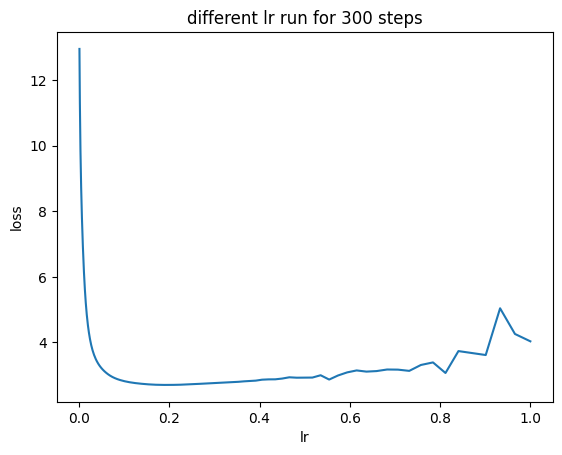

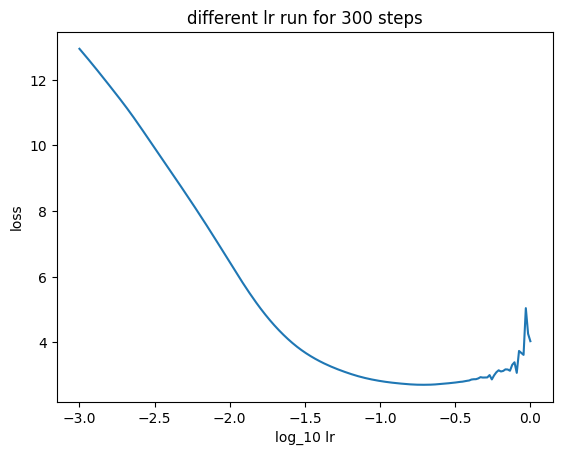

In [88]:
bs = 64
n_steps = 300
n_runs = 200

lre = torch.linspace(-3, 0, n_runs)
lri = 10 ** lre
lossi = []

for run in range(n_runs):
    lr = lri[run]

    torch.manual_seed(42)
    C = torch.randn(27, 2)
    w1 = torch.randn(6, 100)
    b1 = torch.randn(100)
    w2 = torch.randn(100, 27)
    b2 = torch.randn(27)
    params = [C, w1, b1, w2, b2]
    for p in params:
        p.requires_grad = True


    for s in range(n_steps):
        x = X_train[s * bs:(s + 1) * bs]
        y = Y_train[s * bs:(s + 1) * bs]
        emb = C[x].view(x.shape[0], -1)
        logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
        loss = F.cross_entropy(logits, y)

        loss.backward()
        for p in params:
            p.data -= lr * p.grad
            p.grad = None
    with torch.no_grad():
        emb = C[X_val].view(X_val.shape[0], -1)
        logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
        val_loss = F.cross_entropy(logits, Y_val)
        print(f"run: {run}, train loss: {loss.item():.4f} val_loss: {val_loss.item():.4f}")
    lossi.append(val_loss.item())
    

plt.plot(lri, lossi)
plt.xlabel('lr')
plt.ylabel('loss')
plt.title(f'different lr run for {n_steps} steps')
plt.show()
plt.plot(lre, lossi)
plt.xlabel('log_10 lr')
plt.ylabel('loss')
plt.title(f'different lr run for {n_steps} steps')
plt.show()


# visualize embedding

In [21]:
import torch.nn.functional as F

n_embd = 2
n_hidden = 100
bs = 64
n_steps = X_train.shape[0] // bs
ini_lr = 0.3
n_epochs = 30


torch.manual_seed(42)
g = torch.Generator().manual_seed(42)

C = torch.randn(27, n_embd)
w1 = torch.randn(3 * n_embd, n_hidden)
b1 = torch.randn(n_hidden)
w2 = torch.randn(n_hidden, 27)
b2 = torch.randn(27)
params = [C, w1, b1, w2, b2]
for p in params:
    p.requires_grad = True



step = 0
for epoch in range(n_epochs):


    indices = torch.randperm(X_train.shape[0], generator=g)
    X_tr, Y_tr = X_train[indices], Y_train[indices]
    for s in range(n_steps):
        x = X_tr[s * bs:(s + 1) * bs]
        y = Y_tr[s * bs:(s + 1) * bs]
        emb = C[x].view(x.shape[0], -1)
        logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
        loss = F.cross_entropy(logits, y)
    
        loss.backward()
        if step % 500 == 0:
            with torch.no_grad():
                emb = C[X_val].view(X_val.shape[0], -1)
                logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
                val_loss = F.cross_entropy(logits, Y_val)
            print(f"epoch: {epoch}, step: {step}, train_loss: {loss.item():.4f}, val_loss: {val_loss.item():.4f}")
        for p in params:
            p.data -= lr * p.grad
            p.grad = None
        
        step += 1
        lr = ini_lr * (1 - 0.9 * step / n_steps / n_epochs)



epoch: 0, step: 0, train_loss: 14.9841, val_loss: 16.7180
epoch: 0, step: 500, train_loss: 2.8562, val_loss: 2.8798
epoch: 0, step: 1000, train_loss: 2.7706, val_loss: 2.6646
epoch: 0, step: 1500, train_loss: 2.4254, val_loss: 2.7023
epoch: 0, step: 2000, train_loss: 2.4937, val_loss: 2.6659
epoch: 0, step: 2500, train_loss: 2.5410, val_loss: 2.5659
epoch: 1, step: 3000, train_loss: 2.5809, val_loss: 2.5270
epoch: 1, step: 3500, train_loss: 2.7894, val_loss: 2.6650
epoch: 1, step: 4000, train_loss: 2.6478, val_loss: 2.6097
epoch: 1, step: 4500, train_loss: 2.4172, val_loss: 2.5899
epoch: 1, step: 5000, train_loss: 2.0297, val_loss: 2.4297
epoch: 2, step: 5500, train_loss: 2.5113, val_loss: 2.5311
epoch: 2, step: 6000, train_loss: 2.6065, val_loss: 2.4758
epoch: 2, step: 6500, train_loss: 2.4746, val_loss: 2.4455
epoch: 2, step: 7000, train_loss: 2.1866, val_loss: 2.4578
epoch: 2, step: 7500, train_loss: 2.6240, val_loss: 2.4741
epoch: 3, step: 8000, train_loss: 2.3632, val_loss: 2.4674

In [22]:
with torch.no_grad():
    emb = C[X_test].view(X_test.shape[0], -1)
    logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
    val_loss = F.cross_entropy(logits, Y_test)

val_loss

tensor(2.2603)

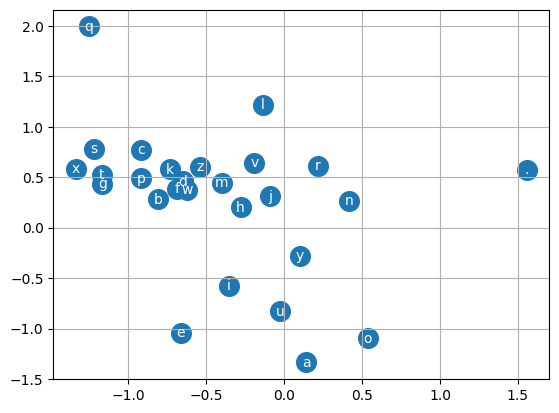

...vanda.
...gwa.
...lhasaushellean.
...kyellien.
...kalamilaandel.
...hosiovonnemilen.
...neh.
...roeleigh.
...shanni.
...stun.



In [ ]:
# plot embedding
import matplotlib.pyplot as plt

data = C.detach().cpu().numpy()


plt.scatter(data[:, 0], data[:, 1], s=200)
for i, ch in enumerate(chs):
    plt.text(data[i, 0], data[i, 1], ch, ha='center', va='center', color='white')
plt.grid('minor')
plt.show()

# generate text
for _ in range(10):
    idx = torch.zeros(1, 3, dtype=torch.long)
    for _ in range(20):
        context = idx[:, -3:]
        emb = C[context].view(context.shape[0], -1)
        logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
        probs = F.softmax(logits, dim=-1)
        next_idx = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_idx], dim=-1)
        if next_idx.item() == 0:
            break
    print(''.join([itos[i.item()] for i in idx[0]]))

# scale hidden layer

In [174]:
n_embd = 2
bs = 64
n_steps = X_train.shape[0] // bs
lr = 0.1
n_epochs = 3

for n_hidden in range(100, 700, 50):

    torch.manual_seed(42)
    g = torch.Generator().manual_seed(42)

    C = torch.randn(27, n_embd)
    w1 = torch.randn(6, n_hidden)
    b1 = torch.randn(n_hidden)
    w2 = torch.randn(n_hidden, 27)
    b2 = torch.randn(27)
    params = [C, w1, b1, w2, b2]
    for p in params:
        p.requires_grad = True



    step = 0
    for epoch in range(n_epochs):


        indices = torch.randperm(X_train.shape[0], generator=g)
        X_tr, Y_tr = X_train[indices], Y_train[indices]
        for s in range(n_steps):
            x = X_tr[s * bs:(s + 1) * bs]
            y = Y_tr[s * bs:(s + 1) * bs]
            emb = C[x].view(x.shape[0], -1)
            logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
            loss = F.cross_entropy(logits, y)
        
            loss.backward()
            if step % 500 == 0:
                with torch.no_grad():
                    emb = C[X_val].view(X_val.shape[0], -1)
                    logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
                    val_loss = F.cross_entropy(logits, Y_val)
            for p in params:
                p.data -= lr * p.grad
                p.grad = None
            
            step += 1
        
    print(f"n_hidden: {n_hidden}, val_loss: {val_loss.item():.4f}")


n_hidden: 100, val_loss: 2.4143
n_hidden: 150, val_loss: 2.4432
n_hidden: 200, val_loss: 2.4774
n_hidden: 250, val_loss: 2.5293
n_hidden: 300, val_loss: 2.5011
n_hidden: 350, val_loss: 2.6146
n_hidden: 400, val_loss: 2.7190
n_hidden: 450, val_loss: 2.6410
n_hidden: 500, val_loss: 2.7278
n_hidden: 550, val_loss: 3.0026
n_hidden: 600, val_loss: 3.0901
n_hidden: 650, val_loss: 2.9924


when scaling hidden layer does not work, the bottleneck may be the embedding layer

In [175]:
n_hidden = 100
bs = 64
n_steps = X_train.shape[0] // bs
lr = 0.1
n_epochs = 3

for n_embd in range(2, 11):

    torch.manual_seed(42)
    g = torch.Generator().manual_seed(42)

    C = torch.randn(27, n_embd)
    w1 = torch.randn(3 * n_embd, n_hidden)
    b1 = torch.randn(n_hidden)
    w2 = torch.randn(n_hidden, 27)
    b2 = torch.randn(27)
    params = [C, w1, b1, w2, b2]
    for p in params:
        p.requires_grad = True



    step = 0
    for epoch in range(n_epochs):


        indices = torch.randperm(X_train.shape[0], generator=g)
        X_tr, Y_tr = X_train[indices], Y_train[indices]
        for s in range(n_steps):
            x = X_tr[s * bs:(s + 1) * bs]
            y = Y_tr[s * bs:(s + 1) * bs]
            emb = C[x].view(x.shape[0], -1)
            logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
            loss = F.cross_entropy(logits, y)
        
            loss.backward()
            if step % 500 == 0:
                with torch.no_grad():
                    emb = C[X_val].view(X_val.shape[0], -1)
                    logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
                    val_loss = F.cross_entropy(logits, Y_val)
            for p in params:
                p.data -= lr * p.grad
                p.grad = None
            
            step += 1
        
    print(f"n_embd: {n_embd}, val_loss: {val_loss.item():.4f}")


n_embd: 2, val_loss: 2.4143
n_embd: 3, val_loss: 2.4279
n_embd: 4, val_loss: 2.3991
n_embd: 5, val_loss: 2.3807
n_embd: 6, val_loss: 2.4189
n_embd: 7, val_loss: 2.4024
n_embd: 8, val_loss: 2.3757
n_embd: 9, val_loss: 2.3898
n_embd: 10, val_loss: 2.3849


In [18]:
n_embd = 10
n_hidden = 200
bs = 64
n_steps = X_train.shape[0] // bs
ini_lr = 0.1
n_epochs = 30


torch.manual_seed(42)
g = torch.Generator().manual_seed(42)

C = torch.randn(27, n_embd)
w1 = torch.randn(3 * n_embd, n_hidden)
b1 = torch.randn(n_hidden)
w2 = torch.randn(n_hidden, 27)
b2 = torch.randn(27)
params = [C, w1, b1, w2, b2]
for p in params:
    p.requires_grad = True



step = 0
for epoch in range(n_epochs):


    indices = torch.randperm(X_train.shape[0], generator=g)
    X_tr, Y_tr = X_train[indices], Y_train[indices]
    for s in range(n_steps):
        x = X_tr[s * bs:(s + 1) * bs]
        y = Y_tr[s * bs:(s + 1) * bs]
        emb = C[x].view(x.shape[0], -1)
        logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
        loss = F.cross_entropy(logits, y)
    
        loss.backward()
        if step % 500 == 0:
            with torch.no_grad():
                emb = C[X_val].view(X_val.shape[0], -1)
                logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
                val_loss = F.cross_entropy(logits, Y_val)
            print(f"epoch: {epoch}, step: {step}, train_loss: {loss.item():.4f}, val_loss: {val_loss.item():.4f}")
        for p in params:
            p.data -= lr * p.grad
            p.grad = None
        
        step += 1
        lr = ini_lr * (1 - 0.9 * step / n_steps / n_epochs)



epoch: 0, step: 0, train_loss: 28.9623, val_loss: 26.6552
epoch: 0, step: 500, train_loss: 5.4492, val_loss: 4.7470
epoch: 0, step: 1000, train_loss: 3.6939, val_loss: 3.6344
epoch: 0, step: 1500, train_loss: 3.3021, val_loss: 3.1032
epoch: 0, step: 2000, train_loss: 3.1161, val_loss: 2.9202
epoch: 0, step: 2500, train_loss: 2.8521, val_loss: 2.8268
epoch: 1, step: 3000, train_loss: 2.6151, val_loss: 2.7451
epoch: 1, step: 3500, train_loss: 2.6302, val_loss: 2.7027
epoch: 1, step: 4000, train_loss: 2.9701, val_loss: 2.6659
epoch: 1, step: 4500, train_loss: 2.6582, val_loss: 2.6127
epoch: 1, step: 5000, train_loss: 2.1126, val_loss: 2.5402
epoch: 2, step: 5500, train_loss: 2.5075, val_loss: 2.5726
epoch: 2, step: 6000, train_loss: 2.6402, val_loss: 2.5555
epoch: 2, step: 6500, train_loss: 2.4457, val_loss: 2.4999
epoch: 2, step: 7000, train_loss: 2.2149, val_loss: 2.4824
epoch: 2, step: 7500, train_loss: 2.6598, val_loss: 2.4937
epoch: 3, step: 8000, train_loss: 2.4000, val_loss: 2.4795

In [20]:
with torch.no_grad():
    emb = C[X_test].view(X_test.shape[0], -1)
    logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
    val_loss = F.cross_entropy(logits, Y_test)

val_loss

tensor(2.2087)

# further improve

In [43]:
# use different number of characters
for n_chs in range(2, 11):

    X, Y = [], []
    for w in words:
        context = '.' * n_chs
        for ch in w + '.':
            x = [stoi[c] for c in context]
            y = stoi[ch]
            X.append(x)
            Y.append(y)
            context = context[1:] + ch

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    n1, n2  = int(0.8 * len(X)), int(0.9 * len(X))

    X_train, X_val, X_test = X.tensor_split([n1, n2])
    Y_train, Y_val, Y_test = Y.tensor_split([n1, n2])

    n_embd = 10
    n_hidden = 200
    bs = 32
    lr = 0.1


    torch.manual_seed(42)
    g = torch.Generator().manual_seed(42)

    C = torch.randn(27, n_embd)
    w1 = torch.randn(n_chs * n_embd, n_hidden)
    b1 = torch.randn(n_hidden)
    w2 = torch.randn(n_hidden, 27)
    b2 = torch.randn(27)
    params = [C, w1, b1, w2, b2]
    for p in params:
        p.requires_grad = True


    n_steps = 10000
    for step in range(n_steps):
        indices = torch.randint(0, X_train.shape[0], (bs,), generator=g)
        x, y = X_train[indices], Y_train[indices]
        emb = C[x].view(x.shape[0], -1)
        logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
        loss = F.cross_entropy(logits, y)

        loss.backward()
        for p in params:
            p.data -= lr * p.grad
            p.grad = None
        
    with torch.no_grad():
        emb = C[X_val].view(X_val.shape[0], -1)
        logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
        val_loss = F.cross_entropy(logits, Y_val)
    print(f"n_chs: {n_chs}, step: {step}, train_loss: {loss.item():.4f}, val_loss: {val_loss.item():.4f}")




n_chs: 2, step: 9999, train_loss: 2.2829, val_loss: 2.6155
n_chs: 3, step: 9999, train_loss: 2.4316, val_loss: 2.5614
n_chs: 4, step: 9999, train_loss: 2.4968, val_loss: 2.4645
n_chs: 5, step: 9999, train_loss: 2.5278, val_loss: 2.6192
n_chs: 6, step: 9999, train_loss: 2.8849, val_loss: 2.7413
n_chs: 7, step: 9999, train_loss: 2.6555, val_loss: 2.7669
n_chs: 8, step: 9999, train_loss: 2.5464, val_loss: 2.7570
n_chs: 9, step: 9999, train_loss: 2.9392, val_loss: 2.7761
n_chs: 10, step: 9999, train_loss: 2.9209, val_loss: 2.8729


In [52]:
n_chs = 3
n_embd = 10
n_hidden = 200
bs = 64
lr = 0.3

X, Y = [], []
for w in words:
    context = '.' * n_chs
    for ch in w + '.':
        x = [stoi[c] for c in context]
        y = stoi[ch]
        X.append(x)
        Y.append(y)
        context = context[1:] + ch

X = torch.tensor(X)
Y = torch.tensor(Y)
n1, n2  = int(0.8 * len(X)), int(0.9 * len(X))

X_train, X_val, X_test = X.tensor_split([n1, n2])
Y_train, Y_val, Y_test = Y.tensor_split([n1, n2])




torch.manual_seed(42)
g = torch.Generator().manual_seed(42)

C = torch.randn(27, n_embd)
w1 = torch.randn(n_chs * n_embd, n_hidden)
b1 = torch.randn(n_hidden)
w2 = torch.randn(n_hidden, 27)
b2 = torch.randn(27)
params = [C, w1, b1, w2, b2]
for p in params:
    p.requires_grad = True



n_steps = 50000
for step in range(n_steps):
    indices = torch.randint(0, X_train.shape[0], (bs,), generator=g)
    x, y = X_train[indices], Y_train[indices]
    emb = C[x].view(x.shape[0], -1)
    logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
    loss = F.cross_entropy(logits, y)

    loss.backward()
    if step % 500 == 0:
        with torch.no_grad():
            emb = C[X_val].view(X_val.shape[0], -1)
            logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
            val_loss = F.cross_entropy(logits, Y_val)
        print(f"step: {step}, train_loss: {loss.item():.4f}, val_loss: {val_loss.item():.4f}")
    for p in params:
        p.data -= lr * p.grad
        p.grad = None
    
    lr = ini_lr if step < n_steps // 2 else ini_lr * 0.1



step: 0, train_loss: 25.4360, val_loss: 26.6552
step: 500, train_loss: 4.0156, val_loss: 4.8318
step: 1000, train_loss: 3.4536, val_loss: 3.7283
step: 1500, train_loss: 2.7483, val_loss: 3.2280
step: 2000, train_loss: 3.2623, val_loss: 2.9687
step: 2500, train_loss: 2.8926, val_loss: 2.8479
step: 3000, train_loss: 3.0932, val_loss: 2.7198
step: 3500, train_loss: 2.9486, val_loss: 2.7152
step: 4000, train_loss: 2.8497, val_loss: 2.6138
step: 4500, train_loss: 2.7223, val_loss: 2.5993
step: 5000, train_loss: 2.1926, val_loss: 2.5718
step: 5500, train_loss: 2.6849, val_loss: 2.5385
step: 6000, train_loss: 2.6708, val_loss: 2.5352
step: 6500, train_loss: 2.4292, val_loss: 2.4734
step: 7000, train_loss: 2.4061, val_loss: 2.4873
step: 7500, train_loss: 2.6267, val_loss: 2.5435
step: 8000, train_loss: 2.6007, val_loss: 2.4735
step: 8500, train_loss: 2.4566, val_loss: 2.4912
step: 9000, train_loss: 2.6508, val_loss: 2.4818
step: 9500, train_loss: 2.4958, val_loss: 2.4125
step: 10000, train_los

In [53]:
with torch.no_grad():
    emb = C[X_test].view(X_test.shape[0], -1)
    logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
    val_loss = F.cross_entropy(logits, Y_test)

val_loss

tensor(2.2202)

# play around for lower loss
- the later the training stage, the smaller the learning rate should be
- bigger batch size with slightly larger learning rate may help further reduce the loss


In [ ]:
# keep tuning the parameters in this block and re-runing to find the lowest loss

bs = 8192
ini_lr = 0.0025
n_steps = 1000
for step in range(n_steps):
    indices = torch.randint(0, X_train.shape[0], (bs,), generator=g)
    x, y = X_train[indices], Y_train[indices]
    emb = C[x].view(x.shape[0], -1)
    logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
    loss = F.cross_entropy(logits, y)

    loss.backward()
    if step % 100 == 0:
        with torch.no_grad():
            emb = C[X_val].view(X_val.shape[0], -1)
            logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
            val_loss = F.cross_entropy(logits, Y_val)
        print(f"step: {step}, train_loss: {loss.item():.4f}, val_loss: {val_loss.item():.4f}")
    for p in params:
        p.data -= lr * p.grad
        p.grad = None
    
    lr = ini_lr # if step < n_steps // 2 else ini_lr * 0.1

step: 0, train_loss: 2.1183, val_loss: 2.1713
step: 100, train_loss: 2.1117, val_loss: 2.1713
step: 200, train_loss: 2.1113, val_loss: 2.1714
step: 300, train_loss: 2.1258, val_loss: 2.1714
step: 400, train_loss: 2.1324, val_loss: 2.1714
step: 500, train_loss: 2.1493, val_loss: 2.1714
step: 600, train_loss: 2.1348, val_loss: 2.1714
step: 700, train_loss: 2.1439, val_loss: 2.1714
step: 800, train_loss: 2.1157, val_loss: 2.1714
step: 900, train_loss: 2.1257, val_loss: 2.1713


In [218]:
with torch.no_grad():
    emb = C[X_test].view(X_test.shape[0], -1)
    logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
    val_loss = F.cross_entropy(logits, Y_test)

val_loss

tensor(2.1492)

In [219]:
g = torch.Generator().manual_seed(42)

for _ in range(10):
    idx = torch.zeros(1, 3, dtype=torch.long)
    for _ in range(20):
        context = idx[:, -3:]
        emb = C[context].view(context.shape[0], -1)
        logits = torch.tanh(emb @ w1 + b1) @ w2 + b2
        probs = F.softmax(logits, dim=-1)
        next_idx = torch.multinomial(probs, num_samples=1, generator=g)
        idx = torch.cat([idx, next_idx], dim=-1)
        if next_idx.item() == 0:
            break
    print(''.join([itos[i.item()] for i in idx[0]]))

...anuelen.
...tia.
...marian.
...dante.
...nariel.
...yana.
...kemah.
...lunan.
...epiannaleilanzi.
...kence.


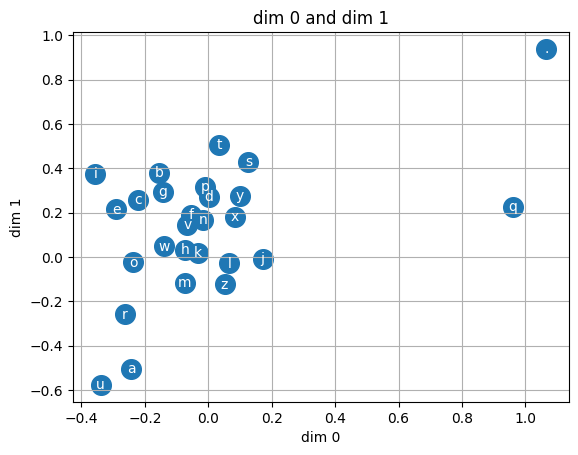

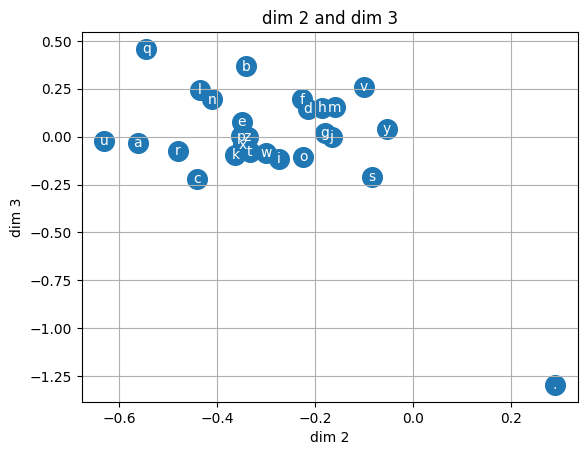

In [220]:
# plot embedding
import matplotlib.pyplot as plt

data = C.detach().cpu().numpy()


plt.scatter(data[:, 0], data[:, 1], s=200)
for i, ch in enumerate(chs):
    plt.text(data[i, 0], data[i, 1], ch, ha='center', va='center', color='white')
plt.grid('minor')
plt.title(f'dim 0 and dim 1')
plt.xlabel('dim 0')
plt.ylabel('dim 1')
plt.show()

plt.scatter(data[:, 2], data[:, 3], s=200)
for i, ch in enumerate(chs):
    plt.text(data[i, 2], data[i, 3], ch, ha='center', va='center', color='white')
plt.grid('minor')
plt.title(f'dim 2 and dim 3')
plt.xlabel('dim 2')
plt.ylabel('dim 3')
plt.show()


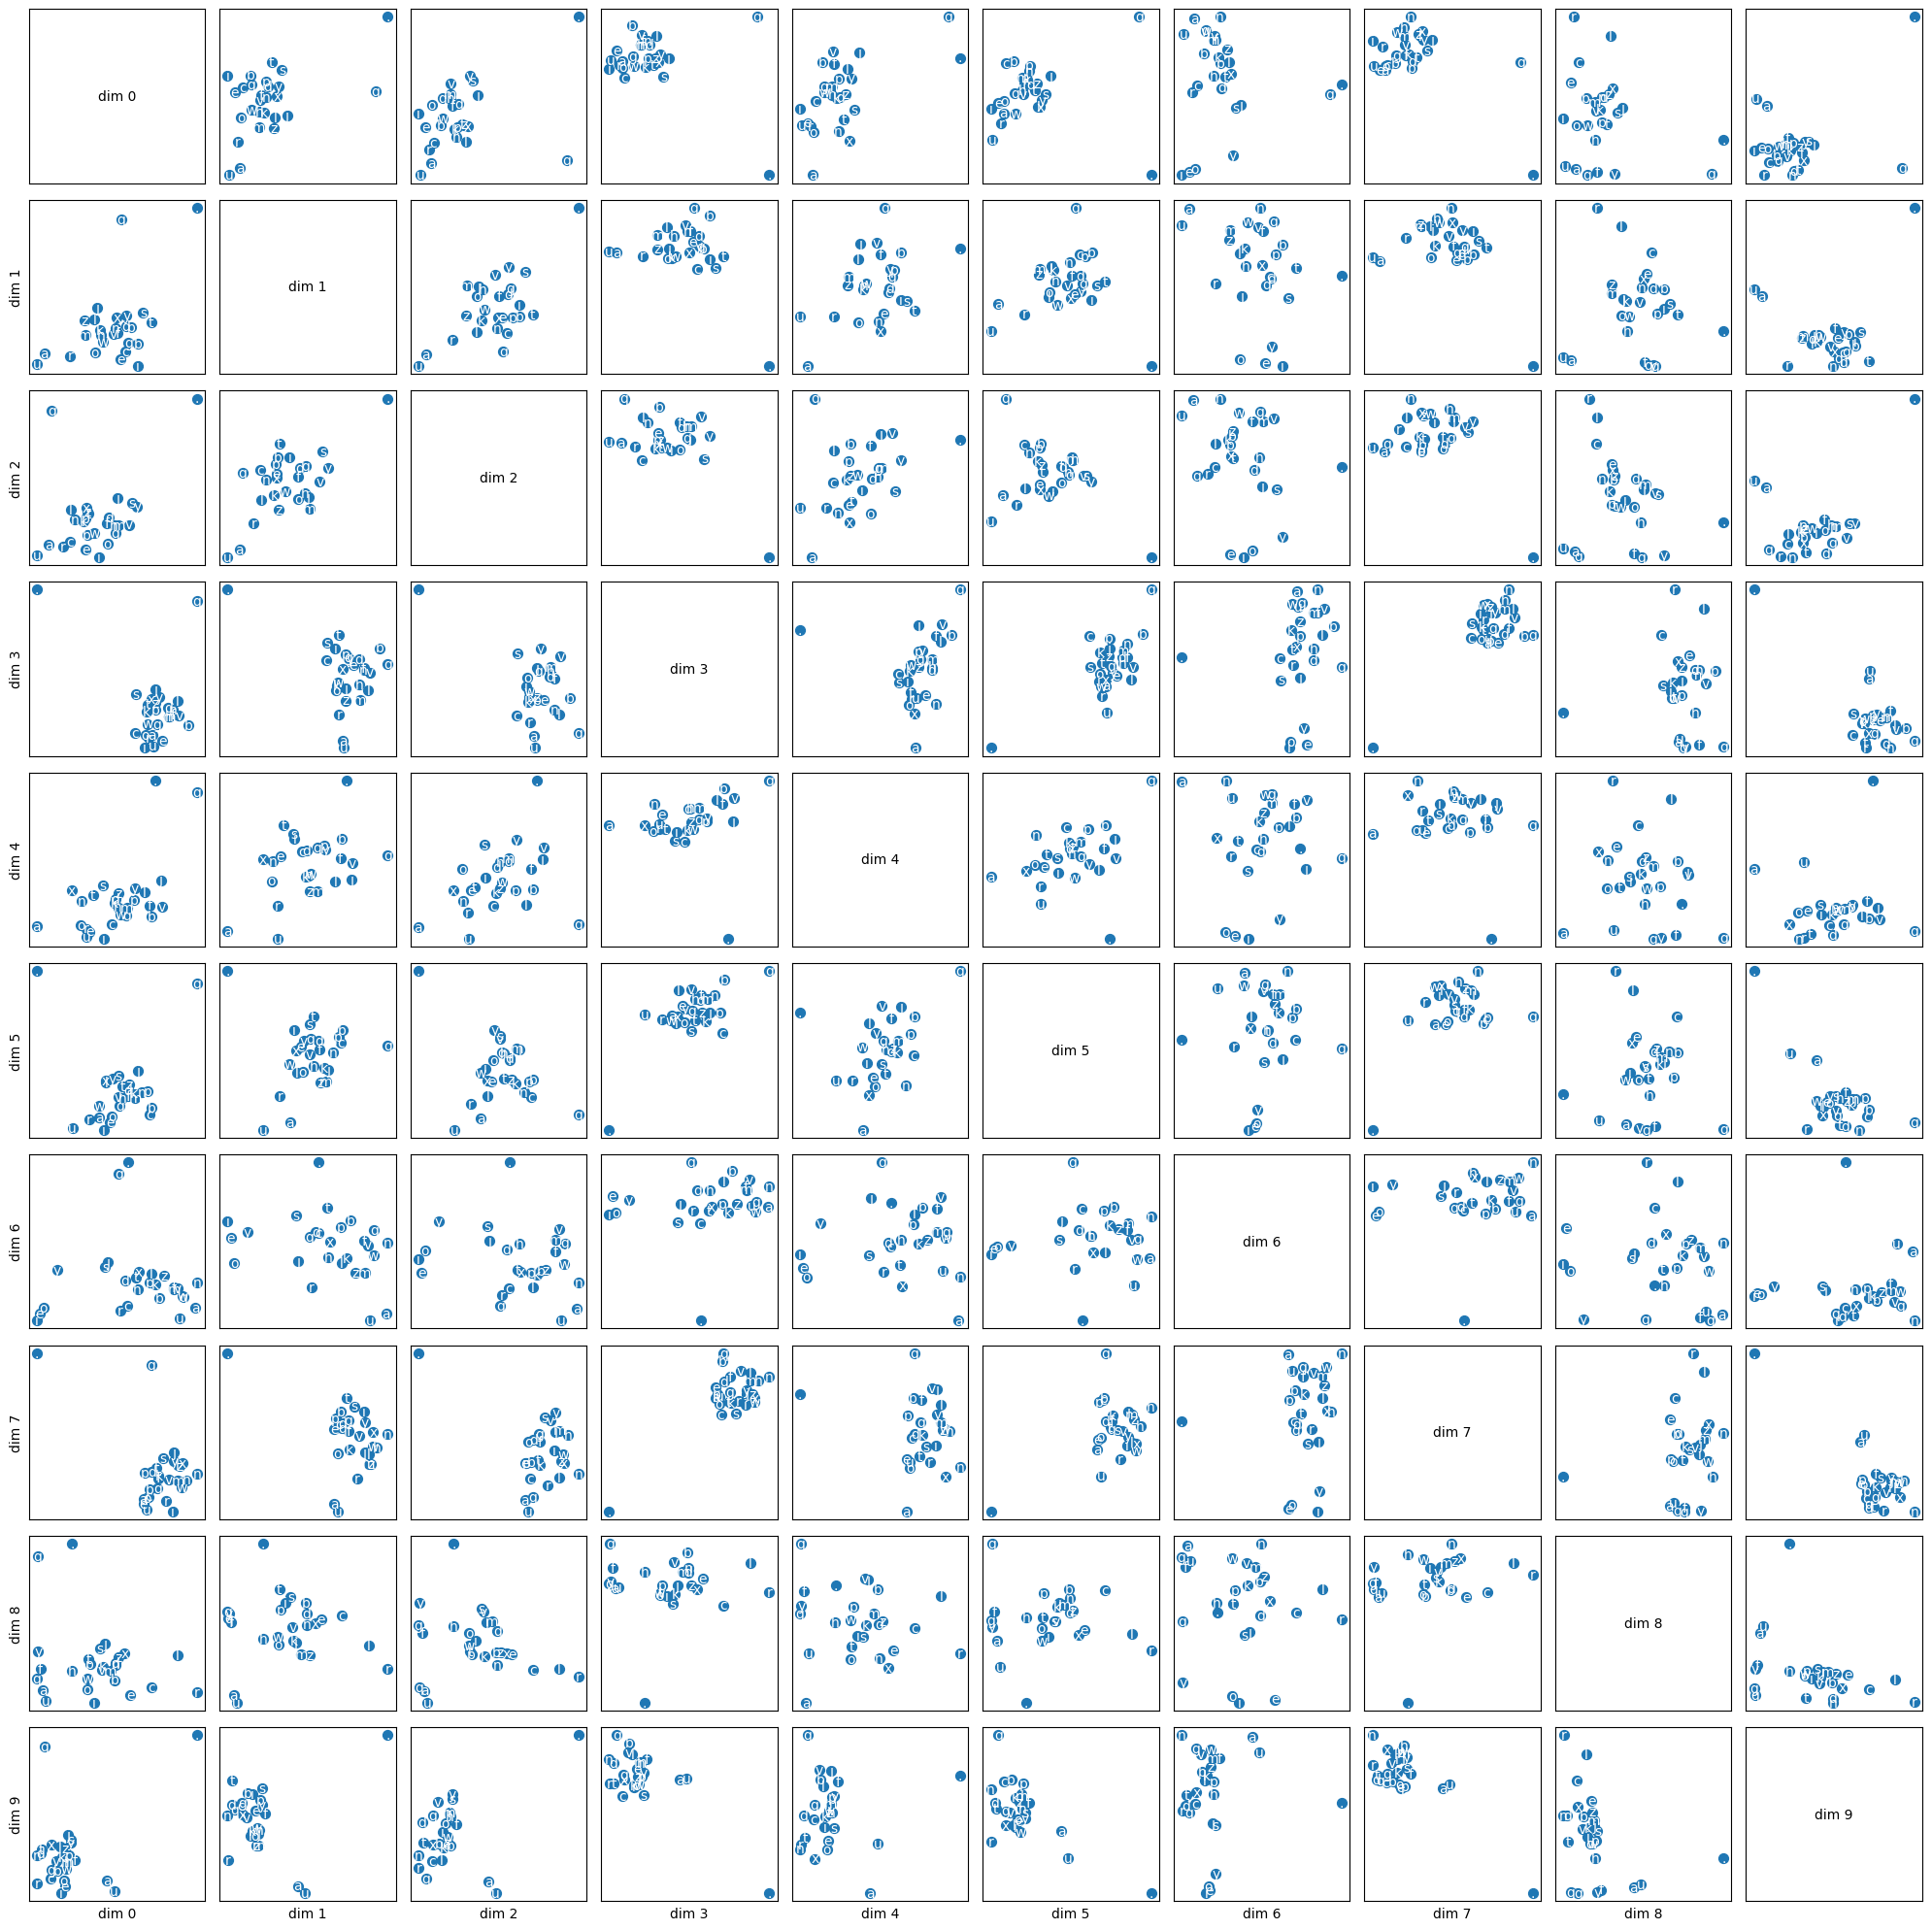

In [221]:
import matplotlib.pyplot as plt

# 创建10x10的子图矩阵
fig, axes = plt.subplots(10, 10, figsize=(20, 20))

# 遍历所有维度对组合
for i in range(10):
    for j in range(10):
        ax = axes[i, j]
        
        # 在对角线上显示维度号
        if i == j:
            ax.text(0.5, 0.5, f'dim {i}', ha='center', va='center')
            ax.set_xticks([])
            ax.set_yticks([])
            continue
            
        # 绘制散点图
        ax.scatter(data[:, i], data[:, j], s=50)
        for k, ch in enumerate(chs):
            ax.text(data[k, i], data[k, j], ch, ha='center', va='center', color='white')
            
        # 设置标签
        if i == 9:  # 最后一行
            ax.set_xlabel(f'dim {j}')
        if j == 0:  # 第一列
            ax.set_ylabel(f'dim {i}')
            
        # 移除刻度
        ax.set_xticks([])
        ax.set_yticks([])
        
# 调整子图之间的间距
plt.tight_layout()
plt.show()

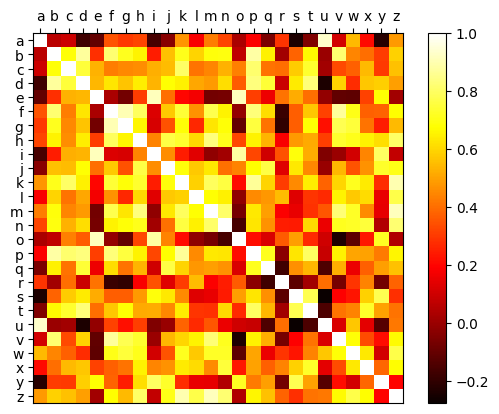

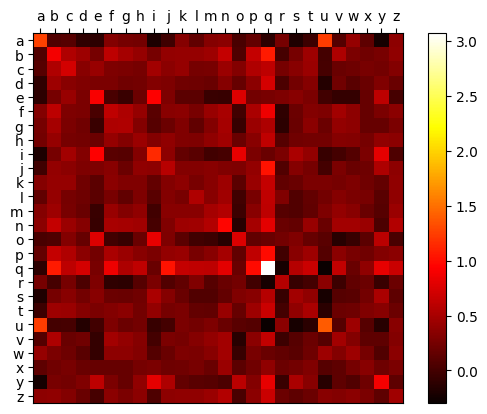

In [230]:
# cosine similarity of rows of C
C_norm = C / C.norm(dim=1, keepdim=True)
data = C_norm @ C_norm.T
data = data.detach().cpu().numpy()

plt.imshow(data[1:,1:], cmap='hot')
plt.xticks(range(26), [chr(i + ord('a')) for i in range(26)])
plt.yticks(range(26), [chr(i + ord('a')) for i in range(26)])
plt.gca().xaxis.set_ticks_position('top')
plt.colorbar()
plt.show()

# inner product of rows of C
data = C @ C.T
data = data.detach().cpu().numpy()

plt.imshow(data[1:,1:], cmap='hot')
plt.xticks(range(26), [chr(i + ord('a')) for i in range(26)])
plt.yticks(range(26), [chr(i + ord('a')) for i in range(26)])
plt.gca().xaxis.set_ticks_position('top')
plt.colorbar()
plt.show()



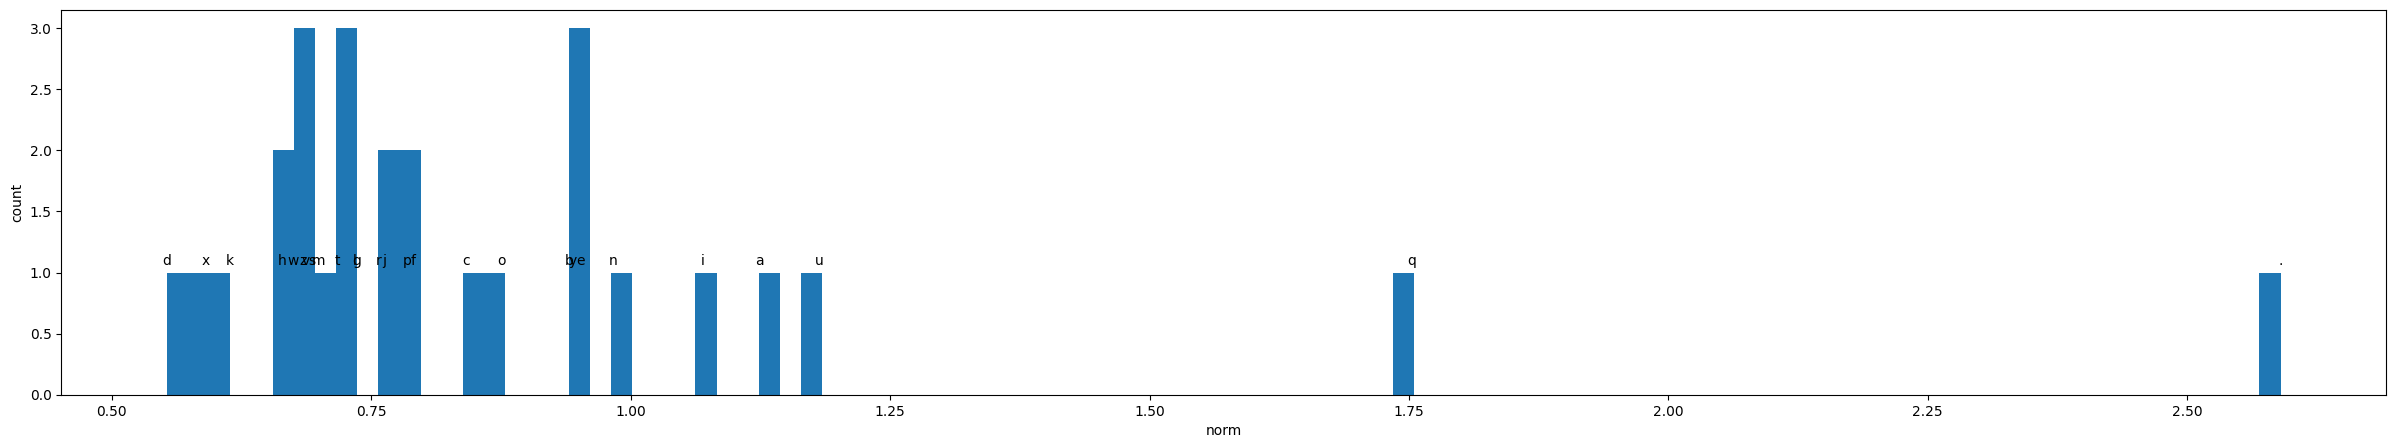

In [248]:
c_norm = C.norm(dim=1)
c_norm = c_norm.detach().cpu().numpy()

plt.figure(figsize=(30, 5))
plt.hist(c_norm, bins=100)
plt.xlabel('norm')
plt.ylabel('count')
for i, ch in enumerate(chs):
    plt.text(c_norm[i], 1.1, ch, ha='center', va='center')
plt.show()


# more model architecture

## compare residual and no residual
residual is little bit better

step: 0, train_loss: 3.3810, val_loss: 3.4007, train_loss2: 3.3991, val_loss2: 3.3570
step: 500, train_loss: 2.1407, val_loss: 2.4224, train_loss2: 2.1389, val_loss2: 2.4138
step: 1000, train_loss: 2.3518, val_loss: 2.3931, train_loss2: 2.3094, val_loss2: 2.3788
step: 1500, train_loss: 2.1206, val_loss: 2.3379, train_loss2: 2.0756, val_loss2: 2.3342
step: 2000, train_loss: 2.3165, val_loss: 2.3383, train_loss2: 2.3854, val_loss2: 2.3371
step: 2500, train_loss: 2.2436, val_loss: 2.3416, train_loss2: 2.1657, val_loss2: 2.3345
step: 3000, train_loss: 2.3682, val_loss: 2.3181, train_loss2: 2.3803, val_loss2: 2.3088
step: 3500, train_loss: 2.3107, val_loss: 2.3486, train_loss2: 2.2604, val_loss2: 2.3543
step: 4000, train_loss: 2.3299, val_loss: 2.2983, train_loss2: 2.3175, val_loss2: 2.2982
step: 4500, train_loss: 2.2286, val_loss: 2.3063, train_loss2: 2.1573, val_loss2: 2.3005
step: 5000, train_loss: 2.0037, val_loss: 2.2977, train_loss2: 2.0487, val_loss2: 2.2895
step: 5500, train_loss: 2

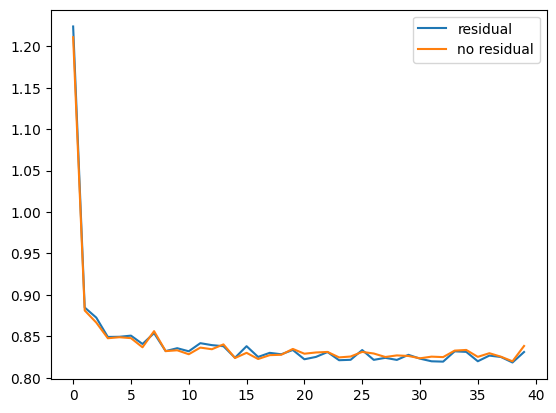

In [257]:
import torch.nn as nn


class Net(nn.Module):
    def __init__(self, n_chs, n_embd, n_hidden, residual=False):
        super().__init__()
        self.C = nn.Embedding(27, n_embd)
        self.fc1 = nn.Linear(n_chs * n_embd, n_hidden)
        if residual:
            self.fcd = nn.Linear(n_chs * n_embd, n_hidden, bias=False)
        self.fc2 = nn.Linear(n_hidden, 27)
        self.residual = residual
    
    def forward(self, x):
        emb = self.C(x).view(x.shape[0], -1)
        hidden = torch.tanh(self.fc1(emb))
        if self.residual:
            hidden = hidden + self.fcd(emb)
        logits = self.fc2(hidden)
        return logits

torch.manual_seed(42)
g = torch.Generator().manual_seed(42)

n_chs = 3
n_embd = 10
n_hidden = 200
bs = 64
ini_lr = 0.0025

net1 = Net(n_chs, n_embd, n_hidden, residual=True)
net2 = Net(n_chs, n_embd, n_hidden, residual=False)
optimizer1 = torch.optim.Adam(net1.parameters(), lr=ini_lr)
optimizer2 = torch.optim.Adam(net2.parameters(), lr=ini_lr)

lossi1, lossi2 = [], []

n_steps = 20000
for step in range(n_steps):
    indices = torch.randint(0, X_train.shape[0], (bs,), generator=g)
    x, y = X_train[indices], Y_train[indices]
    logits1 = net1(x)
    loss1 = F.cross_entropy(logits1, y)
    logits2 = net2(x)
    loss2 = F.cross_entropy(logits2, y)

    loss1.backward()
    loss2.backward()
    if step % 500 == 0:
        with torch.no_grad():
            logits1 = net1(X_val)
            val_loss1 = F.cross_entropy(logits1, Y_val)
            logits2 = net2(X_val)
            val_loss2 = F.cross_entropy(logits2, Y_val)
        print(f"step: {step}, train_loss: {loss1.item():.4f}, val_loss: {val_loss1.item():.4f}, train_loss2: {loss2.item():.4f}, val_loss2: {val_loss2.item():.4f}")
        lossi1.append(val_loss1.log().item())
        lossi2.append(val_loss2.log().item())

    optimizer1.step()
    optimizer1.zero_grad()
    optimizer2.step()
    optimizer2.zero_grad()
    
    lr = ini_lr if step < n_steps // 2 else ini_lr * 0.1

plt.plot(lossi1, label='residual')
plt.plot(lossi2, label='no residual')
plt.legend()
plt.show()

In [258]:
with torch.no_grad():
    logits1 = net1(X_test)
    val_loss1 = F.cross_entropy(logits1, Y_test)
    logits2 = net2(X_test)
    val_loss2 = F.cross_entropy(logits2, Y_test)

val_loss1, val_loss2

(tensor(2.2536), tensor(2.2644))

In [260]:
g = torch.Generator().manual_seed(42)

for _ in range(10):
    idx = torch.zeros(1, 3, dtype=torch.long)
    for _ in range(20):
        context = idx[:, -3:]
        emb = net1.C(context).view(context.shape[0], -1)
        logits = net1(context)
        probs = F.softmax(logits, dim=-1)
        next_idx = torch.multinomial(probs, num_samples=1, generator=g)
        idx = torch.cat([idx, next_idx], dim=-1)
        if next_idx.item() == 0:
            break
    print(''.join([itos[i.item()] for i in idx[0]]))

print()
g = torch.Generator().manual_seed(42)

for _ in range(10):
    idx = torch.zeros(1, 3, dtype=torch.long)
    for _ in range(20):
        context = idx[:, -3:]
        emb = net2.C(context).view(context.shape[0], -1)
        logits = net2(context)
        probs = F.softmax(logits, dim=-1)
        next_idx = torch.multinomial(probs, num_samples=1, generator=g)
        idx = torch.cat([idx, next_idx], dim=-1)
        if next_idx.item() == 0:
            break
    print(''.join([itos[i.item()] for i in idx[0]]))

...anueden.
...tis.
...marian.
...dante.
...namillaylen.
...keman.
...luman.
...epracellen.
...dazi.
...ana.

...anueden.
...tie.
...mariel.
...dante.
...nariel.
...yana.
...kemah.
...lunan.
...epracelle.
...jamzi.


##  better activation function

In [270]:
import torch.nn as nn


class Net(nn.Module):
    def __init__(self, n_chs, n_embd, n_hidden):
        super().__init__()
        self.C = nn.Embedding(27, n_embd)
        self.fc1 = nn.Linear(n_chs * n_embd, n_hidden)
        self.fcd = nn.Linear(n_chs * n_embd, n_hidden, bias=False)
        self.fc2 = nn.Linear(n_hidden, 27)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        emb = self.C(x).view(x.shape[0], -1)
        hidden = self.relu(self.fc1(emb)) + self.fcd(emb)
        logits = self.fc2(hidden)
        return logits

torch.manual_seed(42)
g = torch.Generator().manual_seed(42)

n_chs = 3
n_embd = 10
n_hidden = 200
bs = 64
ini_lr = 0.0025

net = Net(n_chs, n_embd, n_hidden)
optimizer = torch.optim.Adam(net.parameters(), lr=ini_lr)


n_steps = 5000
for step in range(n_steps):
    indices = torch.randint(0, X_train.shape[0], (bs,), generator=g)
    x, y = X_train[indices], Y_train[indices]
    logits = net(x)
    loss = F.cross_entropy(logits, y)

    loss.backward()
    if step % 500 == 0:
        with torch.no_grad():
            logits = net(X_val)
            val_loss = F.cross_entropy(logits, Y_val)
        print(f"step: {step}, train_loss: {loss.item():.4f}, val_loss: {val_loss.item():.4f}")

    optimizer.step()
    optimizer.zero_grad()
    
    lr = ini_lr if step < n_steps // 2 else ini_lr * 0.1


step: 0, train_loss: 3.4185, val_loss: 3.4159
step: 500, train_loss: 2.0892, val_loss: 2.3773
step: 1000, train_loss: 2.3407, val_loss: 2.3556
step: 1500, train_loss: 2.0465, val_loss: 2.3001
step: 2000, train_loss: 2.2837, val_loss: 2.2889
step: 2500, train_loss: 2.1628, val_loss: 2.2770
step: 3000, train_loss: 2.3029, val_loss: 2.2694
step: 3500, train_loss: 2.2446, val_loss: 2.2652
step: 4000, train_loss: 2.2880, val_loss: 2.2483
step: 4500, train_loss: 2.1219, val_loss: 2.2348


## more layers

In [274]:
class Net(nn.Module):
    def __init__(self, n_chs, n_embd, n_hidden):
        super().__init__()
        self.C = nn.Embedding(27, n_embd)
        self.fc1 = nn.Linear(n_chs * n_embd, n_hidden)
        self.fcd = nn.Linear(n_chs * n_embd, n_hidden, bias=False)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, 27)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        emb = self.C(x).view(x.shape[0], -1)
        hidden = self.relu(self.fc1(emb)) + self.fcd(emb)
        hidden = self.relu(self.fc2(hidden)) + hidden
        logits = self.fc3(hidden)
        return logits

torch.manual_seed(42)
g = torch.Generator().manual_seed(42)

n_chs = 3
n_embd = 10
n_hidden = 200
bs = 64
ini_lr = 0.0025

net = Net(n_chs, n_embd, n_hidden)
optimizer = torch.optim.Adam(net.parameters(), lr=ini_lr)


n_steps = 10000
for step in range(n_steps):
    indices = torch.randint(0, X_train.shape[0], (bs,), generator=g)
    x, y = X_train[indices], Y_train[indices]
    logits = net(x)
    loss = F.cross_entropy(logits, y)

    loss.backward()
    if step % 500 == 0:
        with torch.no_grad():
            logits = net(X_val)
            val_loss = F.cross_entropy(logits, Y_val)
        print(f"step: {step}, train_loss: {loss.item():.4f}, val_loss: {val_loss.item():.4f}")

    optimizer.step()
    optimizer.zero_grad()
    
    lr = ini_lr if step < n_steps // 2 else ini_lr * 0.1


step: 0, train_loss: 3.5222, val_loss: 3.4600
step: 500, train_loss: 2.1025, val_loss: 2.3587
step: 1000, train_loss: 2.3403, val_loss: 2.3558
step: 1500, train_loss: 2.0259, val_loss: 2.2852
step: 2000, train_loss: 2.1703, val_loss: 2.2827
step: 2500, train_loss: 2.1875, val_loss: 2.2594
step: 3000, train_loss: 2.3041, val_loss: 2.2451
step: 3500, train_loss: 2.2240, val_loss: 2.2416
step: 4000, train_loss: 2.2640, val_loss: 2.2278
step: 4500, train_loss: 2.0761, val_loss: 2.2163
step: 5000, train_loss: 2.0268, val_loss: 2.2264
step: 5500, train_loss: 2.3119, val_loss: 2.2432
step: 6000, train_loss: 2.2956, val_loss: 2.2138
step: 6500, train_loss: 2.2615, val_loss: 2.2135
step: 7000, train_loss: 2.3135, val_loss: 2.2035
step: 7500, train_loss: 1.9859, val_loss: 2.2134
step: 8000, train_loss: 2.3249, val_loss: 2.2031
step: 8500, train_loss: 2.1696, val_loss: 2.2061
step: 9000, train_loss: 2.1559, val_loss: 2.2030
step: 9500, train_loss: 2.1501, val_loss: 2.2097


In [273]:
class Net(nn.Module):
    def __init__(self, n_chs, n_embd, n_hidden):
        super().__init__()
        self.C = nn.Embedding(27, n_embd)
        self.fc1 = nn.Linear(n_chs * n_embd, n_hidden)
        self.fcd = nn.Linear(n_chs * n_embd, n_hidden, bias=False)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.fc4 = nn.Linear(n_hidden, 27)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        emb = self.C(x).view(x.shape[0], -1)
        hidden = self.relu(self.fc1(emb)) + self.fcd(emb)
        hidden = self.relu(self.fc2(hidden)) + hidden
        hidden = self.relu(self.fc3(hidden)) + hidden
        logits = self.fc4(hidden)
        return logits

torch.manual_seed(42)
g = torch.Generator().manual_seed(42)

n_chs = 3
n_embd = 10
n_hidden = 200
bs = 64
ini_lr = 0.0025

net = Net(n_chs, n_embd, n_hidden)
optimizer = torch.optim.Adam(net.parameters(), lr=ini_lr)


n_steps = 10000
for step in range(n_steps):
    indices = torch.randint(0, X_train.shape[0], (bs,), generator=g)
    x, y = X_train[indices], Y_train[indices]
    logits = net(x)
    loss = F.cross_entropy(logits, y)

    loss.backward()
    if step % 500 == 0:
        with torch.no_grad():
            logits = net(X_val)
            val_loss = F.cross_entropy(logits, Y_val)
        print(f"step: {step}, train_loss: {loss.item():.4f}, val_loss: {val_loss.item():.4f}")

    optimizer.step()
    optimizer.zero_grad()
    
    lr = ini_lr if step < n_steps // 2 else ini_lr * 0.1


step: 0, train_loss: 3.3715, val_loss: 3.5573
step: 500, train_loss: 2.0448, val_loss: 2.3627
step: 1000, train_loss: 2.3171, val_loss: 2.3513
step: 1500, train_loss: 1.9563, val_loss: 2.2891
step: 2000, train_loss: 2.2528, val_loss: 2.2883
step: 2500, train_loss: 2.1014, val_loss: 2.2714
step: 3000, train_loss: 2.3673, val_loss: 2.2589
step: 3500, train_loss: 2.1915, val_loss: 2.2453
step: 4000, train_loss: 2.2722, val_loss: 2.2342
step: 4500, train_loss: 2.1189, val_loss: 2.2197
step: 5000, train_loss: 2.0253, val_loss: 2.2117
step: 5500, train_loss: 2.2841, val_loss: 2.2432
step: 6000, train_loss: 2.2481, val_loss: 2.2196
step: 6500, train_loss: 2.2979, val_loss: 2.2220
step: 7000, train_loss: 2.2811, val_loss: 2.2082
step: 7500, train_loss: 1.9906, val_loss: 2.2163
step: 8000, train_loss: 2.3124, val_loss: 2.2106
step: 8500, train_loss: 2.1695, val_loss: 2.2092
step: 9000, train_loss: 2.1867, val_loss: 2.2152
step: 9500, train_loss: 2.1932, val_loss: 2.2077


In [276]:
class Net(nn.Module):
    def __init__(self, n_chs, n_embd, n_hidden):
        super().__init__()
        self.C = nn.Embedding(27, n_embd)
        self.fc1 = nn.Linear(n_chs * n_embd, n_hidden)
        self.fcd = nn.Linear(n_chs * n_embd, n_hidden, bias=False)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.fc4 = nn.Linear(n_hidden, n_hidden)
        self.fc5 = nn.Linear(n_hidden, n_hidden)
        self.fc6 = nn.Linear(n_hidden, n_hidden)
        self.fco = nn.Linear(n_hidden, 27)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        emb = self.C(x).view(x.shape[0], -1)
        hidden = self.relu(self.fc1(emb)) + self.fcd(emb)
        hidden = self.relu(self.fc2(hidden)) + hidden
        hidden = self.relu(self.fc3(hidden)) + hidden
        hidden = self.relu(self.fc4(hidden)) + hidden
        hidden = self.relu(self.fc5(hidden)) + hidden
        hidden = self.relu(self.fc6(hidden)) + hidden
        logits = self.fco(hidden)
        return logits

torch.manual_seed(42)
g = torch.Generator().manual_seed(42)

n_chs = 3
n_embd = 10
n_hidden = 200
bs = 64
ini_lr = 0.0025

net = Net(n_chs, n_embd, n_hidden)
optimizer = torch.optim.Adam(net.parameters(), lr=ini_lr)


n_steps = 10000
for step in range(n_steps):
    indices = torch.randint(0, X_train.shape[0], (bs,), generator=g)
    x, y = X_train[indices], Y_train[indices]
    logits = net(x)
    loss = F.cross_entropy(logits, y)

    loss.backward()
    if step % 500 == 0:
        with torch.no_grad():
            logits = net(X_val)
            val_loss = F.cross_entropy(logits, Y_val)
        print(f"step: {step}, train_loss: {loss.item():.4f}, val_loss: {val_loss.item():.4f}")

    optimizer.step()
    optimizer.zero_grad()
    
    lr = ini_lr if step < n_steps // 2 else ini_lr * 0.1


step: 0, train_loss: 3.6925, val_loss: 3.4936
step: 500, train_loss: 2.1255, val_loss: 2.3353
step: 1000, train_loss: 2.2628, val_loss: 2.2945
step: 1500, train_loss: 1.9780, val_loss: 2.2491
step: 2000, train_loss: 2.2032, val_loss: 2.2335
step: 2500, train_loss: 2.0559, val_loss: 2.2282
step: 3000, train_loss: 2.2796, val_loss: 2.2163
step: 3500, train_loss: 2.1438, val_loss: 2.2019
step: 4000, train_loss: 2.2158, val_loss: 2.1910
step: 4500, train_loss: 2.0426, val_loss: 2.1790
step: 5000, train_loss: 2.0710, val_loss: 2.1731
step: 5500, train_loss: 2.2358, val_loss: 2.1957
step: 6000, train_loss: 2.2253, val_loss: 2.1764
step: 6500, train_loss: 2.2224, val_loss: 2.1720
step: 7000, train_loss: 2.2160, val_loss: 2.1608
step: 7500, train_loss: 1.9474, val_loss: 2.1645
step: 8000, train_loss: 2.1668, val_loss: 2.1620
step: 8500, train_loss: 2.0605, val_loss: 2.1637
step: 9000, train_loss: 2.0934, val_loss: 2.1570
step: 9500, train_loss: 2.1083, val_loss: 2.1587


In [290]:
class Net(nn.Module):
    def __init__(self, n_chs, n_embd, n_hidden):
        super().__init__()
        self.C = nn.Embedding(27, n_embd)
        self.fc1 = nn.Linear(n_chs * n_embd, n_hidden)
        self.fcd = nn.Linear(n_chs * n_embd, n_hidden, bias=False)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.fc4 = nn.Linear(n_hidden, n_hidden)
        self.fc5 = nn.Linear(n_hidden, n_hidden)
        self.fc6 = nn.Linear(n_hidden, n_hidden)
        self.fc7 = nn.Linear(n_hidden, n_hidden)
        self.fc8 = nn.Linear(n_hidden, n_hidden)
        self.fc9 = nn.Linear(n_hidden, n_hidden)
        self.fc10 = nn.Linear(n_hidden, n_hidden)
        self.fco = nn.Linear(n_hidden, 27)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        emb = self.C(x).view(x.shape[0], -1)
        hidden = self.relu(self.fc1(emb)) + self.fcd(emb)
        hidden = self.relu(self.fc2(hidden)) + hidden
        hidden = self.relu(self.fc3(hidden)) + hidden
        hidden = self.relu(self.fc4(hidden)) + hidden
        hidden = self.relu(self.fc5(hidden)) + hidden
        hidden = self.relu(self.fc6(hidden)) + hidden
        hidden = self.relu(self.fc7(hidden)) + hidden
        hidden = self.relu(self.fc8(hidden)) + hidden
        hidden = self.relu(self.fc9(hidden)) + hidden
        hidden = self.relu(self.fc10(hidden)) + hidden
        logits = self.fco(hidden)
        return logits

torch.manual_seed(42)
g = torch.Generator().manual_seed(42)

n_chs = 3
n_embd = 10
n_hidden = 200
bs = 64
ini_lr = 0.001

net = Net(n_chs, n_embd, n_hidden)
optimizer = torch.optim.Adam(net.parameters(), lr=ini_lr)


n_steps = 20000
for step in range(n_steps):
    indices = torch.randint(0, X_train.shape[0], (bs,), generator=g)
    x, y = X_train[indices], Y_train[indices]
    logits = net(x)
    loss = F.cross_entropy(logits, y)

    loss.backward()
    if step % 500 == 0:
        with torch.no_grad():
            logits = net(X_val)
            val_loss = F.cross_entropy(logits, Y_val)
        print(f"step: {step}, train_loss: {loss.item():.4f}, val_loss: {val_loss.item():.4f}")

    optimizer.step()
    optimizer.zero_grad()
    
    lr = ini_lr if step < n_steps // 2 else ini_lr * 0.1


step: 0, train_loss: 7.0655, val_loss: 6.9590
step: 500, train_loss: 2.1333, val_loss: 2.3345
step: 1000, train_loss: 2.2982, val_loss: 2.2984
step: 1500, train_loss: 1.9657, val_loss: 2.2445
step: 2000, train_loss: 2.1658, val_loss: 2.2296
step: 2500, train_loss: 2.0976, val_loss: 2.2261
step: 3000, train_loss: 2.2428, val_loss: 2.2173
step: 3500, train_loss: 2.1374, val_loss: 2.2010
step: 4000, train_loss: 2.1956, val_loss: 2.1951
step: 4500, train_loss: 2.0711, val_loss: 2.1793
step: 5000, train_loss: 2.0292, val_loss: 2.1746
step: 5500, train_loss: 2.2163, val_loss: 2.1921
step: 6000, train_loss: 2.2278, val_loss: 2.1787
step: 6500, train_loss: 2.2263, val_loss: 2.1699
step: 7000, train_loss: 2.2113, val_loss: 2.1658
step: 7500, train_loss: 1.9336, val_loss: 2.1608
step: 8000, train_loss: 2.1491, val_loss: 2.1612
step: 8500, train_loss: 2.1020, val_loss: 2.1635
step: 9000, train_loss: 2.0311, val_loss: 2.1589
step: 9500, train_loss: 2.0923, val_loss: 2.1618
step: 10000, train_loss:

In [291]:
with torch.no_grad():
    logits = net(X_test)
    val_loss = F.cross_entropy(logits, Y_test)

val_loss


tensor(2.1326)

In [292]:
g = torch.Generator().manual_seed(42)

for _ in range(10):
    idx = torch.zeros(1, 3, dtype=torch.long)
    for _ in range(20):
        context = idx[:, -3:]
        emb = net.C(context).view(context.shape[0], -1)
        logits = net(context)
        probs = F.softmax(logits, dim=-1)
        next_idx = torch.multinomial(probs, num_samples=1, generator=g)
        idx = torch.cat([idx, next_idx], dim=-1)
        if next_idx.item() == 0:
            break
    print(''.join([itos[i.item()] for i in idx[0]]))

...anuelen.
...tis.
...marian.
...danie.
...naziya.
...yana.
...kemah.
...lucin.
...emiah.
...nasilaniy.
